# Notebook summary of work 

In [10]:
# parent_folder_path = "/Users/haleyoro/Desktop/" # work on library computer
parent_folder_path = "/Users/Haley/Desktop/Neuroscience Lab/Repository/" # work on local computer

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyabf

Looking at the waveforms (from `Plotting` folder)

Annotations sheet --`App Script`--> unformatted csv files 

unformatted csv files --`process_excel`--> formatted csv files 

## `annotations_loader` : Make `sheets` dict with 38 dataframes of all processed .csvs

Load the cell types data frame to include info when reading .csv sheets

In [11]:
cell_types_df = pd.read_csv(parent_folder_path+"murray-neuroscience-lab/Excel processor/List of cells.csv")
cell_types_df = cell_types_df.dropna(how='all')
cell_types_df = cell_types_df.iloc[:,:4]
cell_types_df.reset_index(drop=True,inplace=True)
sheets_types = cell_types_df["Cell"].unique().tolist()
print("Number of labeled sheets:",len(sheets_types))

Number of labeled sheets: 29


Create a dictionary looping through sheet names to load each sheet annotation as a data frame 
(.csv files were re-formatted using functions in `process_excel`, looping through the downloaded excel sheets from the annotations sheet in google drive. excel sheets were downloaded as .csvs using App Script code)

In [13]:
sheet_names_df = pd.read_csv(parent_folder_path+'murray-neuroscience-lab/Processed CSVs/sheet_names.csv', header=None)
sheet_names = sheet_names_df.iloc[:,0].values
sheets = {}

for sheet in sheet_names:
    file_path = parent_folder_path+"murray-neuroscience-lab/Processed CSVs/"+sheet+".csv"
    df = pd.read_csv(file_path)
    df[["Trace name","Tags","Type"]] = df[["Trace name","Tags","Type"]].astype("string")
    if sheet in sheets_types:
        types = cell_types_df[cell_types_df["Cell"]==sheet]
        if not df.empty:
            df.loc[:,"Cell Type"] = types.iloc[0]["Cell Type"]
            df.loc[:,"Input Resistance"] = types.iloc[0]["Input Resistance"]
            df.loc[:,"Motoneuron"] = types.iloc[0]["Motoneuron"]
    sheets[sheet] = df

sheets

{'2012_04_25_cell1':           Trace name  ID  On time     Freq               Tags        Type  \
 0    2012_04_25_0004   1  1285.99      NaN  bout start; shock  Inhibitory   
 1    2012_04_25_0004   2  1305.92  50.1756               <NA>  Inhibitory   
 2    2012_04_25_0004   3  1340.95  28.5470               <NA>  Inhibitory   
 3    2012_04_25_0004   4  1371.30  32.9489               <NA>  Inhibitory   
 4    2012_04_25_0004   5  1405.23  29.4724           bout end  Inhibitory   
 ..               ...  ..      ...      ...                ...         ...   
 153  2012_04_25_0002  13  4726.57  39.7141               <NA>  Excitatory   
 154  2012_04_25_0002  14  4755.30  34.8068               <NA>  Excitatory   
 155  2012_04_25_0002  15  4780.80  39.2157               <NA>  Excitatory   
 156  2012_04_25_0002  16  4808.89  35.5999               <NA>  Excitatory   
 157  2012_04_25_0002  17  4846.59  26.5252           bout end  Excitatory   
 
      Seconds Cell Type  Input Resistance 

In [14]:
unlabeled = list(set(sheet_names) - set(sheets_types))
print("Unlabeled annotation sheets:", unlabeled)


Unlabeled annotation sheets: ['2013_03_21_cell2', '2012_10_04_cell1', '2012_12_06_cell3', '2012_06_22_cell3', '2012_12_04_cell2', '2012_12_06_cell5', '2012_12_06_cell6', '2012_06_25_cell3', '2012_04_27_cell1', '2012_12_06_cell2']


Keys are names of sheets

In [15]:
print("Number of sheets:", len(sheets.keys()))
print("Number of labeled sheets:",len(sheets_types))
sheets.keys()

Number of sheets: 39
Number of labeled sheets: 29


dict_keys(['2012_04_25_cell1', '2012_04_25_cell3', '2012_04_27_cell1', '2012_06_22_cell3', '2012_06_25_cell3', '2012_06_29', '2012_08_01_cell1', '2012_08_01_cell3', '2012_08_07', '2012_08_31_cell1', '2012_08_31_cell2', '2012_08_31_cell3', '2012_08_31_cell4', '2012_10_04_cell2', '2012_12_03_cell1', '2012_12_04_cell1', '2012_12_04_cell2', '2012_12_05_cell1', '2012_12_05_cell3', '2012_12_05_cell4', '2012_12_06_cell1', '2012_12_06_cell2', '2012_12_06_cell3', '2012_12_06_cell4', '2012_12_06_cell5', '2012_12_06_cell6', '2013_03_20_cell1', '2013_03_21_cell1', '2013_03_21_cell2', '2013_03_21_cell3', '2013_03_21_cell4', '2013_03_21_cell5', '2013_03_22_cell1', '2013_03_22_cell2', '2013_03_22_cell3', '2013_03_22_cell4', '2013_03_22_cell5', '2013_03_22_cell6', '2012_10_04_cell1'])

Using one sheet name to access the formatted dataframe of the annotations, includes cell type and resistance

In [19]:
sheets['2012_04_25_cell1']

,Trace name,ID,On time,Freq,Tags,Type,Seconds,Cell Type,Input Resistance,Motoneuron
0,2012_04_25_0004,1,1285.99,NaN,bout start; shock,Inhibitory,1.28599,vRoP,74.45,primary
1,2012_04_25_0004,2,1305.92,50.1756,<NA>,Inhibitory,1.30592,vRoP,74.45,primary
2,2012_04_25_0004,3,1340.95,28.5470,<NA>,Inhibitory,1.34095,vRoP,74.45,primary
3,2012_04_25_0004,4,1371.30,32.9489,<NA>,Inhibitory,1.37130,vRoP,74.45,primary
4,2012_04_25_0004,5,1405.23,29.4724,bout end,Inhibitory,1.40523,vRoP,74.45,primary
...,...,...,...,...,...,...,...,...,...,...
153,2012_04_25_0002,13,4726.57,39.7141,<NA>,Excitatory,4.72657,vRoP,74.45,primary
154,2012_04_25_0002,14,4755.30,34.8068,<NA>,Excitatory,4.75530,vRoP,74.45,primary
155,2012_04_25_0002,15,4780.80,39.2157,<NA>,Excitatory,4.78080,vRoP,74.45,primary
156,2012_04_25_0002,16,4808.89,35.5999,<NA>,Excitatory,4.80889,vRoP,74.45,primary


In [17]:
sheets['2013_03_21_cell2']

,Trace name,ID,On time,Freq,Tags,Type,Seconds
0,2013_03_21_0009,1.0,8573.84,NaN,bout start; spontaneous,Cell-attached,8.57384
1,2013_03_21_0009,2.0,8628.92,18.1554,<NA>,Cell-attached,8.62892
2,2013_03_21_0009,3.0,8679.99,19.5810,<NA>,Cell-attached,8.67999
3,2013_03_21_0009,4.0,8723.59,22.9358,bout end,Cell-attached,8.72359
4,2013_03_21_0009,5.0,11015.75,0.4363,bout start; spontaneous,Cell-attached,11.01575
...,...,...,...,...,...,...,...
685,2013_03_21_0010,511.0,48910.10,29.0951,<NA>,Cell-attached,48.91010
686,2013_03_21_0010,512.0,48952.29,23.7023,<NA>,Cell-attached,48.95229
687,2013_03_21_0010,513.0,48994.36,23.7699,<NA>,Cell-attached,48.99436
688,2013_03_21_0010,514.0,49033.96,25.2525,bout end,Cell-attached,49.03396


## `binwaves_` : make abfs dict to store .abf files for each of the 38 sheets

make `abfs` dict: contains the abf file of each trace in the annotation df sheet

In [128]:
def make_waveforms(abf,df):
    '''
    Function that takes an abf file and a df of the annotations
    Returns a dictionary with waveforms labeled by their frequency
    '''
    abf.setSweep(sweepNumber=0, channel=0)
    x = abf.sweepX
    y = abf.sweepY
    abf_df = pd.DataFrame({
        'Time': x,
        'Current': y
    })
    # print("abf_df head:", abf_df.head())  # Check if abf_df is populated correctly

    # df["On time"] = pd.to_numeric(df["On time"], errors="coerce")
    df["Seconds"] = df['On time']*0.001
    waveforms = {}
    for i in range(len(df) - 1):
        t_0 = df.iloc[i]["Seconds"]
        t_f = df.iloc[i+1]["Seconds"]
        print(t_0,t_f)
        # phase_0 = int(t_0 * 100000)
        # phase_1 = int(t_f * 100000)
        # abf_waveform = abf_df.loc[phase_0:phase_1].copy()
        abf_waveform = abf_df[(abf_df["Time"] >= t_0) & (abf_df["Time"] <= t_f)].copy()
        # print(f"abf_waveform shape (i={i}):", abf_waveform.shape) 
        print(abf_waveform)
        phase = (abf_waveform["Time"] - t_0) / (t_f - t_0)
        abf_waveform["Phase"] = phase
        
        # NORMALIZE CURRENT ALSO, test this:
        
        # y_max = max(abf_waveform["Current"])
        # y_min = min(abf_waveform["Current"])
        # normalized = (abf_waveform["Current"] - y_min) / (y_max - y_min)
        # abf_waveform["Normalized Current"] = normalized
        #=====

        # Dict keys
        freq = 1 / (t_f-t_0) # CHECK = df.loc[i + 1, "Freq"]
        signal_type = df.iloc[0]["Type"]
        cell_type = df.iloc[0]["Cell Type"]
        fast_slow = df.iloc[0]["Motoneuron"] # 8:resistance 9:prim/sec low/high rin need to see what is fast/slow
        key = (freq,signal_type,cell_type,fast_slow)
        waveforms[key] = abf_waveform



    return waveforms

need abfs[trace] and sheets[sheet[sheet["Trace name"]==Trace]]. test with one:

use loops in annotations loader to make mega dict

In [20]:
parent_folder_path_ABFS = "/Users/Haley/Desktop/ABF files annotated/"

TEST: add nested dicts with abf files into `sheets` 

In [100]:
for sheet in sheets.keys():
    df = sheets[sheet]
    traces = df["Trace name"].unique().tolist() # creates an array of the trace names annotated in the sheet
    # load the abf files for each sheet into a dictionary 
    abfs = {}
    for trace in traces:
        abfs[trace] = []
        if trace == "2012_03_21_0027":
            continue
        else:
            file_path2 = parent_folder_path_ABFS + trace +".abf"
            abf = pyabf.ABF(file_path2)
            abfs[trace]= abf
    # adds the dictionary to sheets 
    sheets[sheet] = {
        "annotations": sheets[sheet],
        "abfs": abfs
    }

In [101]:
sheets['2012_04_25_cell1']

{'annotations':           Trace name  ID  On time     Freq               Tags        Type  \
 0    2012_04_25_0004   1  1285.99      NaN  bout start; shock  Inhibitory   
 1    2012_04_25_0004   2  1305.92  50.1756               <NA>  Inhibitory   
 2    2012_04_25_0004   3  1340.95  28.5470               <NA>  Inhibitory   
 3    2012_04_25_0004   4  1371.30  32.9489               <NA>  Inhibitory   
 4    2012_04_25_0004   5  1405.23  29.4724           bout end  Inhibitory   
 ..               ...  ..      ...      ...                ...         ...   
 153  2012_04_25_0002  13  4726.57  39.7141               <NA>  Excitatory   
 154  2012_04_25_0002  14  4755.30  34.8068               <NA>  Excitatory   
 155  2012_04_25_0002  15  4780.80  39.2157               <NA>  Excitatory   
 156  2012_04_25_0002  16  4808.89  35.5999               <NA>  Excitatory   
 157  2012_04_25_0002  17  4846.59  26.5252           bout end  Excitatory   
 
      Seconds Cell Type  Input Resistance Moton

In [53]:
sheets['2013_03_21_cell5']["annotations"]

,Trace name,ID,On time,Freq,Tags,Type,Seconds,Cell Type,Input Resistance,Motoneuron
0,2013_03_21_0049,1,21148.96,NaN,bout start; shock,Excitatory,21.14896,CaP,33.0,primary
1,2013_03_21_0049,2,21188.59,25.2334,<NA>,Excitatory,21.18859,CaP,33.0,primary
2,2013_03_21_0049,3,21219.25,32.6158,<NA>,Excitatory,21.21925,CaP,33.0,primary
3,2013_03_21_0049,4,21246.64,36.5097,<NA>,Excitatory,21.24664,CaP,33.0,primary
4,2013_03_21_0049,5,21284.79,26.2123,<NA>,Excitatory,21.28479,CaP,33.0,primary
...,...,...,...,...,...,...,...,...,...,...
337,2013_03_21_0046,134,48124.72,22.2074,<NA>,Cell-attached,48.12472,CaP,33.0,primary
338,2013_03_21_0046,135,48163.52,25.7732,<NA>,Cell-attached,48.16352,CaP,33.0,primary
339,2013_03_21_0046,136,48201.48,26.3435,<NA>,Cell-attached,48.20148,CaP,33.0,primary
340,2013_03_21_0046,137,48248.26,21.3767,<NA>,Cell-attached,48.24826,CaP,33.0,primary


In [54]:
sheets['2013_03_21_cell5']["abfs"]

{'2013_03_21_0049': ABF (v2.0) with 3 channels (pA, mV, mV), sampled at 100.0 kHz, containing 5 sweeps, having no tags, with a total length of 1.00 minutes, recorded with protocol "Ch1PatchCh2Root_VClamp". path=/Users/Haley/Desktop/ABF files annotated/2013_03_21_0049.abf,
 '2013_03_21_0045': ABF (v2.0) with 3 channels (pA, mV, mV), sampled at 100.0 kHz, containing 5 sweeps, having no tags, with a total length of 1.00 minutes, recorded with protocol "Ch1PatchCh2Root_VClamp". path=/Users/Haley/Desktop/ABF files annotated/2013_03_21_0045.abf,
 '2013_03_21_0046': ABF (v2.0) with 3 channels (pA, mV, mV), sampled at 100.0 kHz, containing 5 sweeps, having no tags, with a total length of 1.00 minutes, recorded with protocol "Ch1PatchCh2Root_VClamp". path=/Users/Haley/Desktop/ABF files annotated/2013_03_21_0046.abf}

Check to see if all abfs successfully loaded

In [115]:
all_equal = []
for sheet in sheets.keys():
    traces_abfs = sorted(sheets[sheet]["abfs"].keys())
    annotations = sheets[sheet]["annotations"]
    traces_annotated = sorted(annotations["Trace name"].unique().tolist())
    # print(num_traces_abfs,num_traces_annotated)
    num_equal = traces_abfs == traces_annotated
    # is_equal = 
    all_equal.append(num_equal)
    # sum(num_traces_abfs == num_traces_annotated)
    # num_traces_annotations = 
sum(all_equal)==len(sheets.keys())

True

In [116]:
print(sheets.keys())
print(sheets_types)

dict_keys(['2012_04_25_cell1', '2012_04_25_cell3', '2012_04_27_cell1', '2012_06_22_cell3', '2012_06_25_cell3', '2012_06_29', '2012_08_01_cell1', '2012_08_01_cell3', '2012_08_07', '2012_08_31_cell1', '2012_08_31_cell2', '2012_08_31_cell3', '2012_08_31_cell4', '2012_10_04_cell2', '2012_12_03_cell1', '2012_12_04_cell1', '2012_12_04_cell2', '2012_12_05_cell1', '2012_12_05_cell3', '2012_12_05_cell4', '2012_12_06_cell1', '2012_12_06_cell2', '2012_12_06_cell3', '2012_12_06_cell4', '2012_12_06_cell5', '2012_12_06_cell6', '2013_03_20_cell1', '2013_03_21_cell1', '2013_03_21_cell2', '2013_03_21_cell3', '2013_03_21_cell4', '2013_03_21_cell5', '2013_03_22_cell1', '2013_03_22_cell2', '2013_03_22_cell3', '2013_03_22_cell4', '2013_03_22_cell5', '2013_03_22_cell6', '2012_10_04_cell1'])
['2013_03_21_cell5', '2013_03_22_cell6', '2013_03_22_cell2', '2012_08_31_cell2', '2012_08_31_cell1', '2012_08_31_cell3', '2013_03_21_cell4', '2012_08_01_cell3', '2013_03_22_cell1', '2013_03_20_cell1', '2013_03_21_cell1',

In [122]:
abf_mkwv

ABF (v2.0) with 3 channels (pA, mV, mV), sampled at 100.0 kHz, containing 5 sweeps, having no tags, with a total length of 1.00 minutes, recorded with protocol "Ch1PatchCh2Root_VClamp". path=/Users/Haley/Desktop/ABF files annotated/2013_03_21_0049.abf

In [123]:
df_mkwv

,Trace name,ID,On time,Freq,Tags,Type,Seconds,Cell Type,Input Resistance,Motoneuron
0,2013_03_21_0049,1,21148.96,NaN,bout start; shock,Excitatory,21.14896,CaP,33.0,primary
1,2013_03_21_0049,2,21188.59,25.2334,<NA>,Excitatory,21.18859,CaP,33.0,primary
2,2013_03_21_0049,3,21219.25,32.6158,<NA>,Excitatory,21.21925,CaP,33.0,primary
3,2013_03_21_0049,4,21246.64,36.5097,<NA>,Excitatory,21.24664,CaP,33.0,primary
4,2013_03_21_0049,5,21284.79,26.2123,<NA>,Excitatory,21.28479,CaP,33.0,primary
5,2013_03_21_0049,6,21328.58,22.8363,<NA>,Excitatory,21.32858,CaP,33.0,primary
6,2013_03_21_0049,7,21365.32,27.2183,<NA>,Excitatory,21.36532,CaP,33.0,primary
7,2013_03_21_0049,8,21400.86,28.1373,bout end,Excitatory,21.40086,CaP,33.0,primary
8,2013_03_21_0049,9,22326.93,1.0798,bout start; shock,Excitatory,22.32693,CaP,33.0,primary
9,2013_03_21_0049,10,22351.45,40.7830,<NA>,Excitatory,22.35145,CaP,33.0,primary


ABF (v2.0) with 3 channels (pA, mV, mV), sampled at 100.0 kHz, containing 5 sweeps, having no tags, with a total length of 1.00 minutes, recorded with protocol "Ch1PatchCh2Root_VClamp". path=/Users/Haley/Desktop/ABF files annotated/2013_03_21_0049.abf

In [129]:
make_waveforms(abf_mkwv,df_mkwv)

Empty DataFrame
Columns: [Time, Current]
Index: []
Empty DataFrame
Columns: [Time, Current]
Index: []
Empty DataFrame
Columns: [Time, Current]
Index: []
Empty DataFrame
Columns: [Time, Current]
Index: []
Empty DataFrame
Columns: [Time, Current]
Index: []
Empty DataFrame
Columns: [Time, Current]
Index: []
Empty DataFrame
Columns: [Time, Current]
Index: []
Empty DataFrame
Columns: [Time, Current]
Index: []
Empty DataFrame
Columns: [Time, Current]
Index: []
Empty DataFrame
Columns: [Time, Current]
Index: []
Empty DataFrame
Columns: [Time, Current]
Index: []
Empty DataFrame
Columns: [Time, Current]
Index: []
Empty DataFrame
Columns: [Time, Current]
Index: []
Empty DataFrame
Columns: [Time, Current]
Index: []
Empty DataFrame
Columns: [Time, Current]
Index: []
Empty DataFrame
Columns: [Time, Current]
Index: []
Empty DataFrame
Columns: [Time, Current]
Index: []
Empty DataFrame
Columns: [Time, Current]
Index: []
Empty DataFrame
Columns: [Time, Current]
Index: []
Empty DataFrame
Columns: [Time,

{(np.float64(25.233409033558843),
  'Excitatory',
  'CaP',
  'primary'): Empty DataFrame
 Columns: [Time, Current, Phase]
 Index: [],
 (np.float64(32.61578604044627),
  'Excitatory',
  'CaP',
  'primary'): Empty DataFrame
 Columns: [Time, Current, Phase]
 Index: [],
 (np.float64(36.50967506389131),
  'Excitatory',
  'CaP',
  'primary'): Empty DataFrame
 Columns: [Time, Current, Phase]
 Index: [],
 (np.float64(26.212319790300285),
  'Excitatory',
  'CaP',
  'primary'): Empty DataFrame
 Columns: [Time, Current, Phase]
 Index: [],
 (np.float64(22.836263987212853),
  'Excitatory',
  'CaP',
  'primary'): Empty DataFrame
 Columns: [Time, Current, Phase]
 Index: [],
 (np.float64(27.21829069134327),
  'Excitatory',
  'CaP',
  'primary'): Empty DataFrame
 Columns: [Time, Current, Phase]
 Index: [],
 (np.float64(28.137310073156204),
  'Excitatory',
  'CaP',
  'primary'): Empty DataFrame
 Columns: [Time, Current, Phase]
 Index: [],
 (np.float64(1.0798319781442016),
  'Excitatory',
  'CaP',
  'pri

: 

In [ ]:
def make_waveforms(abf,df):
    '''
    Function that takes an abf file and a df of the annotations
    Returns a dictionary with waveforms labeled by their frequency
    '''
    abf.setSweep(sweepNumber=0, channel=0)
    x = abf.sweepX
    y = abf.sweepY
    abf_df = pd.DataFrame({
        'Time': x,
        'Current': y
    })
    # df["On time"] = pd.to_numeric(df["On time"], errors="coerce")
    # df["Seconds"] = df['On time']*0.001
    waveforms = {}
    for i in range(len(df) - 1):
        t_0 = df.iloc[i,6] 
        t_f = df.iloc[i+1,6]
        phase_0 = int(t_0 * 100000)
        phase_1 = int(t_f * 100000)
        abf_waveform = abf_df.loc[phase_0:phase_1]
        print(abf_waveform)
        phase = (abf_waveform["Time"] - t_0) / (t_f - t_0)
        abf_waveform["Phase"] = phase
        
        # NORMALIZE CURRENT ALSO, test this:
        
        # y_max = max(abf_waveform["Current"])
        # y_min = min(abf_waveform["Current"])
        # normalized = (abf_waveform["Current"] - y_min) / (y_max - y_min)
        # abf_waveform["Normalized Current"] = normalized
        #=====

        # Dict keys
        freq = 1 / (t_f-t_0) # CHECK = df.loc[i + 1, "Freq"]
        cell_type = df.iloc[0,5]
        signal_type = df.iloc[0,7]
        fast_slow = df.iloc[0,9] # 8:resistance 9:prim/sec low/high rin need to see what is fast/slow
        key = (freq,cell_type,signal_type,fast_slow)
        waveforms[key] = abf_waveform

    return waveforms

TEST: loop to use `sheets` to make a dict `all_waveforms`

In [119]:
all_waveforms = {}
for sheet in sheets_types: # using sheet_types instead of sheet_keys() since not all sheets are labeled
    # print(sheet)
    traces_df_mkwf = sheets[sheet]["annotations"]
    # print(traces_df_mkwf)
    abfs_mkwv = sheets[sheet]["abfs"]
    # print(abfs_mkwv)

    traces = traces_df_mkwf["Trace name"].unique().tolist()
    # print(traces)
    for trace in traces:
        abf_mkwv = abfs_mkwv[trace]
        print(abf_mkwv)
        df_mkwv = traces_df_mkwf[traces_df_mkwf["Trace name"]==trace]
        print(df_mkwv)

        waveforms = make_waveforms(abf_mkwv,df_mkwv)

        for key, value in waveforms.items():
            combined_key = f"{sheet}_{trace}_{key}"  
            all_waveforms[combined_key] = value

ABF (v2.0) with 3 channels (pA, mV, mV), sampled at 100.0 kHz, containing 5 sweeps, having no tags, with a total length of 1.00 minutes, recorded with protocol "Ch1PatchCh2Root_VClamp".
         Trace name  ID   On time      Freq               Tags        Type  \
0   2013_03_21_0049   1  21148.96       NaN  bout start; shock  Excitatory   
1   2013_03_21_0049   2  21188.59   25.2334               <NA>  Excitatory   
2   2013_03_21_0049   3  21219.25   32.6158               <NA>  Excitatory   
3   2013_03_21_0049   4  21246.64   36.5097               <NA>  Excitatory   
4   2013_03_21_0049   5  21284.79   26.2123               <NA>  Excitatory   
5   2013_03_21_0049   6  21328.58   22.8363               <NA>  Excitatory   
6   2013_03_21_0049   7  21365.32   27.2183               <NA>  Excitatory   
7   2013_03_21_0049   8  21400.86   28.1373           bout end  Excitatory   
8   2013_03_21_0049   9  22326.93    1.0798  bout start; shock  Excitatory   
9   2013_03_21_0049  10  22351.45 

ValueError: max() iterable argument is empty

In [70]:
def bin_wave(onewave):
    # Make edges for the bin
    bins = np.linspace(0, 1, 51, endpoint = True)

    # Cut the phase into bins
    onewave['Phase Bin'] = pd.cut(onewave['Phase'], bins=bins, include_lowest=True)
    # print(onewave)

    # Group by the bins and calculate the average current
    # binned_avg = onewave.groupby(by='Phase Bin','Current')
    binned_avg = onewave.groupby('Phase Bin')[['Current','Normalized Current']].mean().reset_index()
    # print(binned_avg)

    # Get phase column for plotting (middle of bin)
    phase = np.arange(0.01, 1.00001, 0.02)
    # len(phase)
    binned_avg['Phase'] = phase
    return binned_avg

In [71]:
bin_wave(waveforms_one_trace[(np.float64(50.17561465127891), 'Inhibitory', 'vRoP', 'primary')])

/var/folders/mw/pz4gm95j6zb7syl48vm11wrw0000gn/T/ipykernel_80297/2164057241.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_avg = onewave.groupby('Phase Bin')[['Current','Normalized Current']].mean().reset_index()


,Phase Bin,Current,Normalized Current,Phase
0,"(-0.001, 0.02]",387.954681,0.054022,0.01
1,"(0.02, 0.04]",412.286316,0.086058,0.03
2,"(0.04, 0.06]",453.933685,0.140891,0.05
3,"(0.06, 0.08]",520.965515,0.229147,0.07
4,"(0.08, 0.1]",552.773987,0.271026,0.09
5,"(0.1, 0.12]",605.160461,0.339999,0.11
6,"(0.12, 0.14]",660.211121,0.412480,0.13
7,"(0.14, 0.16]",711.372498,0.479840,0.15
8,"(0.16, 0.18]",714.892517,0.484474,0.17
9,"(0.18, 0.2]",732.162415,0.507212,0.19


In [72]:
bin_table = bin_wave(waveforms_one_trace[(np.float64(50.17561465127891), 'Inhibitory', 'vRoP', 'primary')])
bin_table

/var/folders/mw/pz4gm95j6zb7syl48vm11wrw0000gn/T/ipykernel_80297/2164057241.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_avg = onewave.groupby('Phase Bin')[['Current','Normalized Current']].mean().reset_index()


,Phase Bin,Current,Normalized Current,Phase
0,"(-0.001, 0.02]",387.954681,0.054022,0.01
1,"(0.02, 0.04]",412.286316,0.086058,0.03
2,"(0.04, 0.06]",453.933685,0.140891,0.05
3,"(0.06, 0.08]",520.965515,0.229147,0.07
4,"(0.08, 0.1]",552.773987,0.271026,0.09
5,"(0.1, 0.12]",605.160461,0.339999,0.11
6,"(0.12, 0.14]",660.211121,0.412480,0.13
7,"(0.14, 0.16]",711.372498,0.479840,0.15
8,"(0.16, 0.18]",714.892517,0.484474,0.17
9,"(0.18, 0.2]",732.162415,0.507212,0.19


<Axes: xlabel='Phase'>

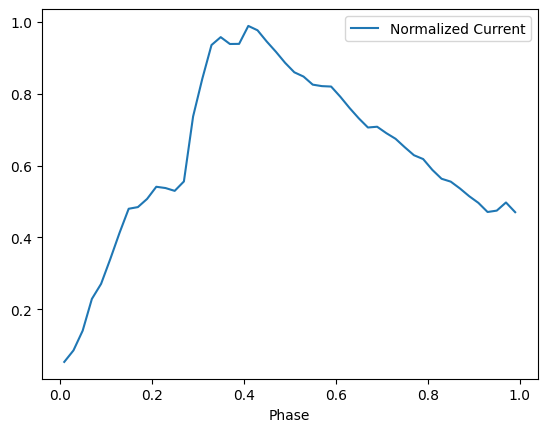

In [74]:
bin_table.plot("Phase","Normalized Current")

bin `all_waveforms` and store in `binned_waveforms`

In [ ]:
binned_waveforms = {}
for wave in all_waveforms.keys():
    binned = bin_wave(all_waveforms[wave])
    binned_waveforms[wave] = binned

NEXT: access keys to average across the key types and plot
- current type: excitatory, inhibitory, cell-attached
- frequency bins:
- rin: low/mid/high or fast/slow
- cell type: CaP,vRoP,MiP,dRoP,dVS,dSMN,vSMN,iSMN

function(current,freq,rin,type) -> plot waveform

In [79]:
for key in waveforms_one_trace:
    print(key[0])

50.17561465127891
primary
28.54695974878684
primary
32.94892915980244
primary
29.4724432655467
primary
